In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset

In [2]:
PERPLEXITY_CUTOFF = 5001


def get_perplexity(meta):
    if isinstance(meta, str):
        meta = ast.literal_eval(meta)
    return int(meta["perplexity_score"])


def get_dataset(dataset_name):
    dataset = pd.DataFrame(load_dataset("datablations/small-" + dataset_name)["train"])

    dataset["perplexity_score"] = dataset.apply(
        lambda doc: get_perplexity(doc["meta"]), axis=1
    )
    dataset["perplexity_score_clipped"] = dataset.apply(
        lambda doc: doc["perplexity_score"]
        if doc["perplexity_score"] < PERPLEXITY_CUTOFF
        else PERPLEXITY_CUTOFF,
        axis=1,
    )
    for column in dataset.columns:
        if column not in [
            "text",
            "perplexity_score",
            "perplexity_score_clipped",
        ]:
            dataset = dataset.drop(column, axis=1)

    dataset = dataset.sort_values("perplexity_score").reset_index()
    return dataset

In [3]:
c4 = get_dataset("c4")
oscar = get_dataset("oscar")

Using custom data configuration datablations--small-c4-e8a6f02cee04263e
Found cached dataset parquet (/home/piktus_huggingface_co/.cache/huggingface/datasets/datablations___parquet/datablations--small-c4-e8a6f02cee04263e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration datablations--small-oscar-6124b442bcb1791d
Found cached dataset parquet (/home/piktus_huggingface_co/.cache/huggingface/datasets/datablations___parquet/datablations--small-oscar-6124b442bcb1791d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
LINE_COLOR = "#1F77B4"
C4_COLOR = "#FAA307"
OSCAR_COLOR = "#DC2F02"
FONTSIZE_SMALL = 16
PERPLEXITY_KEY = "perplexity_score_clipped"
BINS = 500

In [5]:
def get_threshold(dataset, perc):
    return dataset["perplexity_score"][len(dataset) * perc]


def plot_percentile_threshold(ax, dataset, perc, y=100):
    threshold = get_threshold(dataset, perc)
    ax.axvline(x=threshold, linewidth=0.5, color=LINE_COLOR)
    ax.text(
        threshold - 90,
        y,
        str(int(perc * 100)) + "th percentile",
        fontsize=FONTSIZE_SMALL,
        rotation=90,
        color=LINE_COLOR,
    )

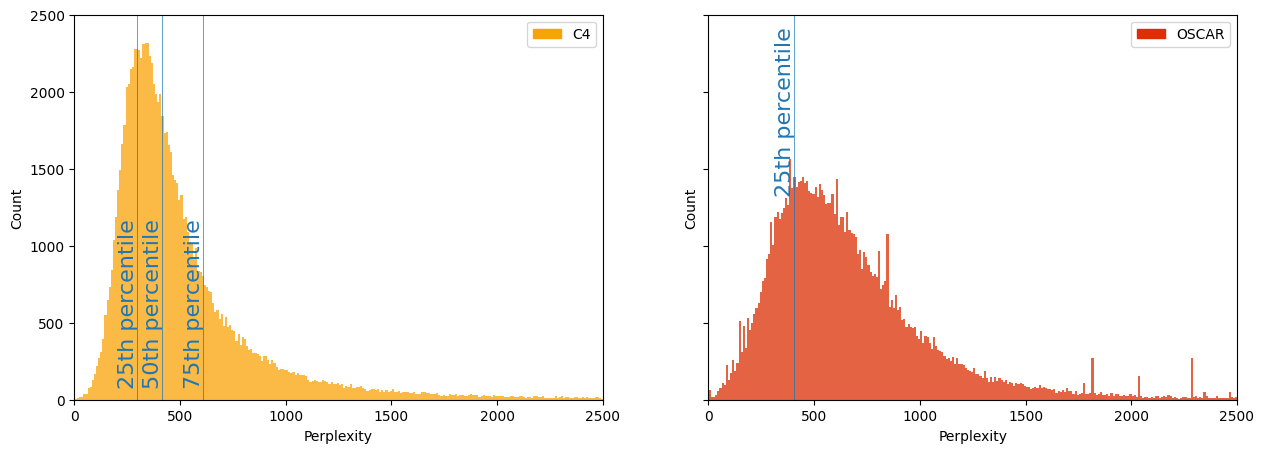

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# c4
axs[0].hist(c4[PERPLEXITY_KEY], BINS, facecolor=C4_COLOR, alpha=0.75)
axs[0].set_xlim(0, 2500)
axs[0].set_ylim(0, 2500)
axs[0].set_xlabel("Perplexity", fontsize=FONTSIZE_SMALL)
axs[0].set_ylabel("Count", fontsize=FONTSIZE_SMALL)
axs[0].legend(frameon=False, fontsize=FONTSIZE_SMALL, handles=[mpatches.Patch(color=C4_COLOR, label="C4")])
axs[0].tick_params(labelsize=FONTSIZE_SMALL)
plot_percentile_threshold(axs[0], c4, 0.25)
plot_percentile_threshold(axs[0], c4, 0.5)
plot_percentile_threshold(axs[0], c4, 0.75)


# oscar
axs[1].hist(oscar[PERPLEXITY_KEY], BINS, facecolor=OSCAR_COLOR, alpha=0.75)
axs[1].set_xlim(0, 2500)
axs[1].set_ylim(0, 2500)
axs[1].set_xlabel("Perplexity", fontsize=FONTSIZE_SMALL)
axs[1].set_ylabel("Count", fontsize=FONTSIZE_SMALL)
axs[1].legend(frameon=False, fontsize=FONTSIZE_SMALL, handles=[mpatches.Patch(color=OSCAR_COLOR, label="OSCAR")])
axs[1].tick_params(labelsize=FONTSIZE_SMALL)
plot_percentile_threshold(axs[1], oscar, 0.25, y=1350)

In [7]:
fig.savefig("perplexity_histogram.pdf", bbox_inches="tight")